In [14]:
import math
import matplotlib.pyplot as plt
import random

14.1 모델

$$y_i = \beta x_i + \alpha + \varepsilon_i$$

y_i는 사용자 i가 매일 사이트에서 보내는 시간(분),

x_i는 사용자 i의 친구 수.

\varepsilon_i는 모델이 고려하지 못한 다른 요소 때문에 발생하는 (아마도 작은)오류.

만약 알파와 베타가 이미 구해졌다면, 다음과 같이 예측 할수있다.

In [3]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

알파와 베타 어떻게 선택할수 있을까?

알파와 베타가 무엇이든 간에 x_i에 대한 결과 예측 가능.

실제 출력값이 y_i가 주어졌으니, 다양한 알파와 베타에 대한 오류 계산 가능.

In [4]:
def error(alpha, beta, x_i, y_i):
    # 실제 결과가 y_i일 떄, beta * x_i + alpha로 계산된 예측값의 오류
    return y_i - predict(alpha, beta, x_i) # y_i - (beta * x_i + alpha)

우리가 정말 알고 싶은 것은 데잍처 전체에서 발생하는 총 오류값.

하지만 무작정 모든 오류값 더하면 x.

만약 x_1의 예측값이 너무 높고 x_2의 예측값이 너무 낮다면, 오류값이 상쇄되기 때문.

그래서! 오류의 제곱값을 더해줘야 함.

In [5]:
def sum_of_squared_errors(alpha, beta, x, y):
    return sum(error(alpha, beta, x_i, y_i)**2
               for x_i, y_i in zip(x,y))

최소자승법이란 sum_of_squared_errors를 최소화해 주는 알파와 베타 값을 찾는 것을 의미

미분을 사용하면 오류를 최소화하는 알파와 베타를 찾을 수 있다.

In [18]:
# 공식 불러오기
def mean(x):
    return sum(x) / len(x)

def de_mean(x):
    # x의 모든 데이터 포인트에서 평균을 뺌 (평균을 0으로 만들기 위해)
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

# 벡터 내적
def dot(v, w):
    # v_1 * w_1 + ... + v_n * w_n
    return sum(v_i*w_i for v_i,w_i in zip(v,w))

# 내적의 개념을 사용한, 각 성분의 제곱 합
def sum_of_squares(v):
    # v_1 * v_1 + ... + v_n*v_n
    return dot(v,v)

def covariance(x,y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n-1)

def correlation(x,y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x,y) / stdev_x / stdev_y
    else:
        return 0 # 편차가 존재하지 않는다면 상관관계는 0이다.
    
def standard_deviation(x):
    return math.sqrt(variance(x))

def variance(x):
    # x에 두 개 이상의 데이터가 있다고 가정
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n-1)

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [7]:
def least_squares_fit(x,y):
    # x와 y가 학습 데이터로 주어졌을 때, 오류의 제곱 값을 최소화해 주는 알파와 베타 계산
    beta = correlation(x,y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta

독립 변수 x의 평균이 주어지면, 알파는 종속 변수 y의 평균을 예측

베타는 입력 변수가 standard_deviation(x)만큼 증가한다면 예측값 또한,

correlation(x,y) * standard_deviation(y)만큼 증가한다는 것을 의미.

만약 x와 y가 완벽한 양의 상관관계를 지닌다면, x가 1 표준편차만큼 증가할 때마다 y 또한 1 표준편차만큼 증가.

만약 x와 y가 완벽한 음의 상관관계를 지닌다면, x가 증가할때마다 y는 감소.

만약 상관관계가 0이라면 베타는 0이며, 이는 x가 예측에 아무런 영향 x

In [8]:
num_friends = [100,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,20.59,27.53,13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,29.79,32.8,35.99,28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,23.48,8.38,27.81,32.35,23.84]
outlier = num_friends.index(100)
num_friends_good = [x
                   for i,x in enumerate(num_friends)
                   if i != outlier]

daily_minutes_good = [x
                     for i,x in enumerate(daily_minutes)
                     if i != outlier]

In [9]:
alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)

print(alpha)
print(beta)

22.94755241346903
0.903865945605865


In [10]:
y_hat = [predict(alpha, beta, x_i) for x_i in num_friends_good]

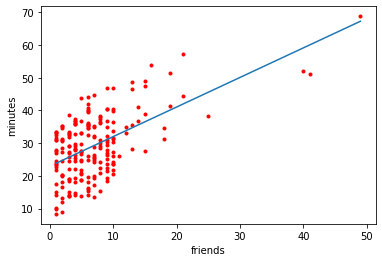

In [11]:
plt.scatter(num_friends_good, daily_minutes_good, marker='.', color='red', label='ys1')
plt.plot(num_friends_good, y_hat, '-')
plt.xlabel('friends')
plt.ylabel('minutes')
plt.show()

결정계수(R 제곱값)란 종속 변수의 총 변화량 중 모델이 잡아낼 수 있는 변화량의 비율

In [12]:
def total_sum_of_squares(y):
    # 평균을 기준으로 y_i의 변화량을 제곱한 값의 총합
    return sum(v **2 for v in de_mean(y))

def r_squared(alpha, beta, x, y):
    # 모델이 잡아낼 수 있는 변화량의 비율은 1 - 모델이 잡아내지 못하는 변화량의 비율로 계산
    return 1.0 - (sum_of_squared_errors(alpha, beta, x,y)/
                 total_sum_of_squares(y))

r_squared(alpha, beta, num_friends_good, daily_minutes_good)

0.3291078377836305

오류의 제곱값을 최소화하는 알파와 베타 구함.

이 밖에 모든 예측값을 mean(y)로 계산해주는 또 다른 모델(알파 = mean(y), 베타 = 0)을 만들 수 있음.

이 경우, 오류를 제곱한 값의 총합은 항상 변화량을 제곱한 값의 총합과 같을 것이며 R 제곱 값은 0이 될 것이다.

즉, 오류의 제곱 값을 최소화하는 모델은 항상 mean(y)로 예측하는 것과 별다른 차이가 없다는 것을 의미.

최소자승법 모델의 성능은 적어도 평균을 예측하는 모델의 성능만큼 좋아야 함.

즉, 오류를 제곱한 값의 총합은 아무리 커봐야 변화량을 제곱한 값의 총합과 동일. 이 경우 R 제곱 값은 0.

그리고 오류를 제곱한 값의 총합은 최소한 0이기 때문에 R 제곱 값의 최댓값은 1이다.

R 제곱 값이 클수록 모델이 데이터에 더 적합하다는 것을 의미.

계산된 R 제곱값은 0.329이기에 만들어진 모델은 어느 정도 적합하나 다른 중요 요소가 존재한다는 의미.

14-2. 경사하강법 사용하기

In [17]:
#이 책 8장의 '걍시히깅법'을 통해 모델 만들기.

def squared_error(x_i, y_i, theta):
    alpha, beta = theta
    return error(alpha, beta, x_i, y_i) ** 2

def squared_error_gradient(x_i, y_i, theta):
    alpha, beta = theta
    return [-2 * error(alpha, beta, x_i, y_i),        #알파에 대한 편미분
            -2 * error(alpha, beta, x_i, y_i) * x_i]  #베타에 대한 편미분

#임의의 알파, 베타값으로 시작
random.seed(0)
theta = [random.random(), random.random()]
alpha, beta = minimize_stochastic(squared_error,
                                 squared_error_gradient,
                                 num_friends_good,
                                 daily_minutes_good,
                                 theta,
                                 0.001)
print(alpha, beta)

NameError: name 'in_random_order' is not defined

14-3. 최대우도추정법(MLE, Maximum Likelihood Estimation
 * 최소 자승법을 사용하는 이유: 최대우도추정법을 사용하기 위함이다.
 * 책의 설명 대신, 아래 링크로 갈음한다

Reference:
    * 밑바닥부터 시작하는 데이터과학 14장
    * https://github.com/EvanOman/Data-Science-from-Scratch/blob/master/Chapter14.ipynb
    * https://ratsgo.github.io/statistics/2017/09/23/MLE/
    * https://datascienceschool.net/view-notebook/79140e6a9e364bcbb04cb8e525b9dba4/